# Experiments for NIPS 2016
---

* ~~Inspect JA, EE trajectories for Clothing Assistance Tasks~~
* ~~Inspect latent trajectories from BGPLVM Models~~
* ~~Fit DMP to Joint Angle trajectories and Latent Space trajectories~~
* ~~Extract via-points from desired trajectory~~
* ~~Generate plots with raw, dmp, desired trajectories and via-points~~
* ~~Time normalize trajectories for cost function~~
* ~~Design cost function to learn desired trajectory~~
* ~~Obtain DMP parameter vectors for Policy~~
* ~~Implement CEM reinforcement learning for JA case~~
* ~~Apply CEM RL to both JA,EE and corresponding latent space models~~
* ~~Compile results of applying RL~~

## Environment Setup
---

In [1]:
# import the modules
import os
import sys
import GPy
import csv
import time
import pydmps
import random
import matplotlib
import numpy as np
from os import listdir
from plotFuncs import *
import cPickle as pickle
from matplotlib import cm
from viapointExtract import *
from os.path import isfile, join
from matplotlib import pyplot as plt
from pydmps.dmp_discrete import DMPs_discrete
from GPy.plotting.matplot_dep.controllers.imshow_controller import ImshowController
from GPy.inference.latent_function_inference import InferenceMethodList, VarDTC, VarDTC_minibatch

%matplotlib notebook

In [2]:
# load the processed dataset
data = pickle.load(open('Data/Data.p','r'))

# load the ja and ee models
jaModels = pickle.load(open('Results/JAModels.p','r'))
eeModels = pickle.load(open('Results/EEModels.p','r'))

# load the experimental results
jaOutputs = pickle.load(open('Results/JAResults.p','rb'))
eeOutputs = pickle.load(open('Results/EEResults.p','rb'))

models = {'JA':jaModels['BGPLVM'],'EE':eeModels['BGPLVM']}

## Data Inspection
---

In [ ]:
# set the train and test data trials
datasets = {}
keys = ['JA','EE']
for ind, key in enumerate(keys):
    trData = data[key]['65']
    tsData = data[key]['75']
    
    trData[:,0] = np.linspace(0.0, 1.0, endpoint=True, num=trData.shape[0], dtype=np.float)
    tsData[:,0] = np.linspace(0.0, 1.0, endpoint=True, num=tsData.shape[0], dtype=np.float)
    
    datasets[key] = {'Train':trData, 'Test':tsData}
    plotTraj(datasets[key], plotType=ind, jointIndex=np.asarray([0,1,2,3,4,5,6]))

## Latent Data Inspection
---

In [ ]:
latentsets = {}

for key in keys:
    (trLatent, tsLatent) = plotLatent(models[key], datasets[key]['Train'][:,1:], datasets[key]['Test'][:,1:])
    trLatent = np.concatenate((np.transpose(np.atleast_2d(datasets[key]['Train'][:,0])),trLatent),axis=1)
    tsLatent = np.concatenate((np.transpose(np.atleast_2d(datasets[key]['Test'][:,0])),tsLatent),axis=1)
    
    # append to dataset dict
    latentsets[key] = {'Train':trLatent,'Test':tsLatent}
    
    # plot latent trajectories
    plotTraj2(latentsets[key])

In [ ]:
Data = {'input':datasets, 'latent':latentsets}
pickle.dump(Data,open('Data/RLData.p','wb'))

## DMP on Trajectories
---

In [3]:
Data = pickle.load(open('Data/RLData.p','rb'))

<IPython.core.display.Javascript object>


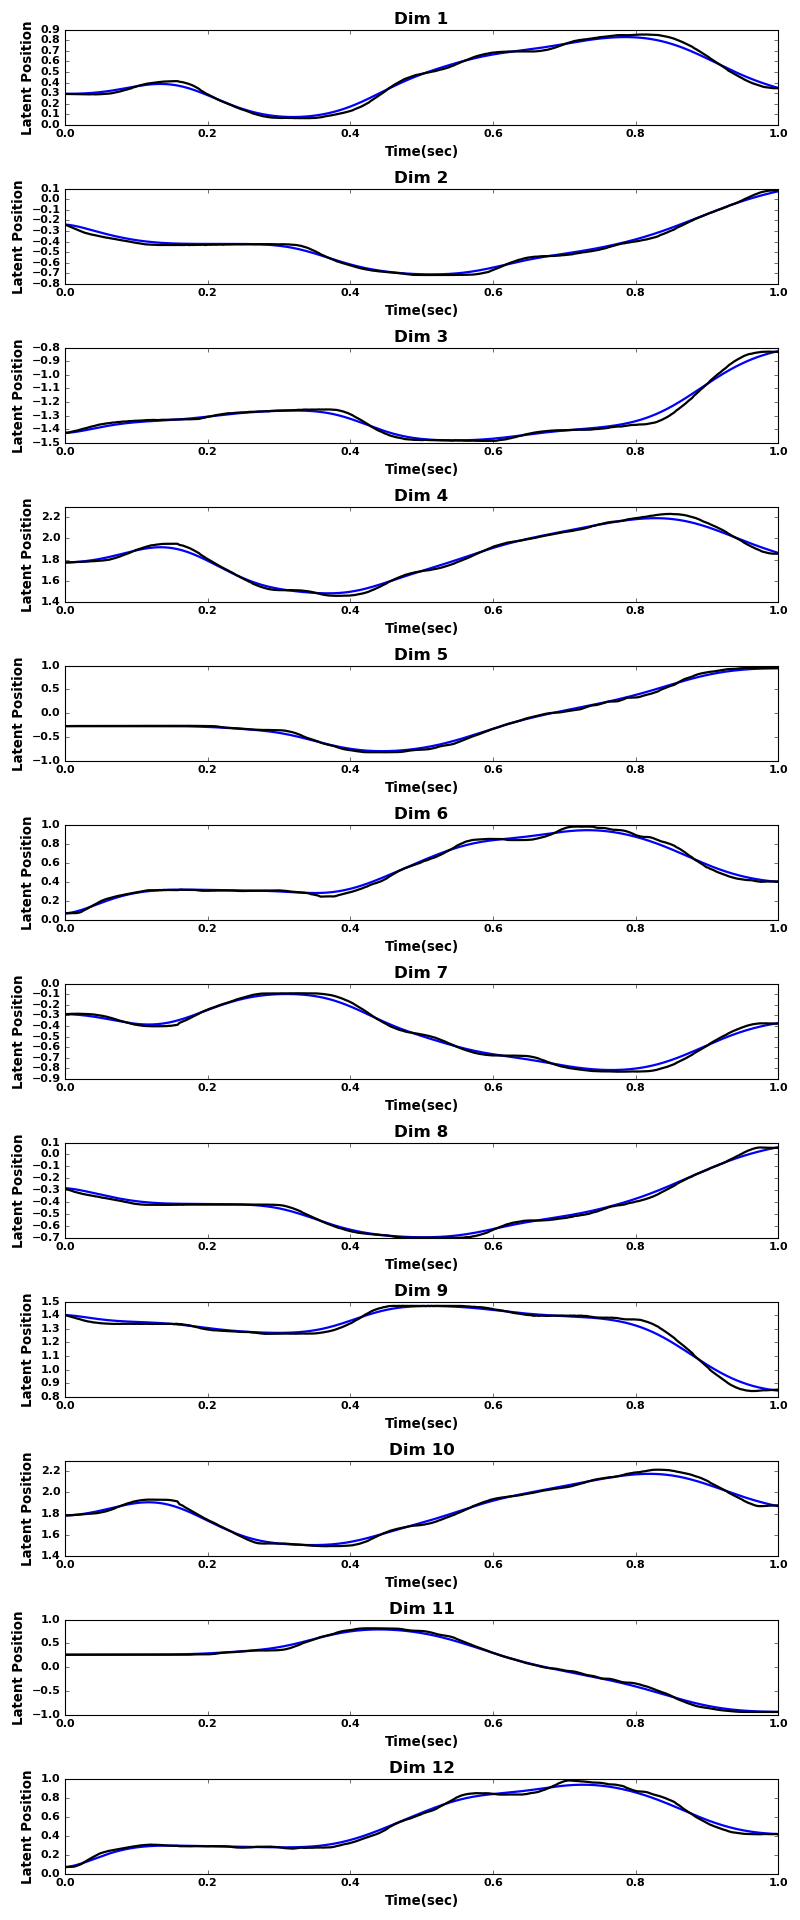

input,JA:Done


<IPython.core.display.Javascript object>


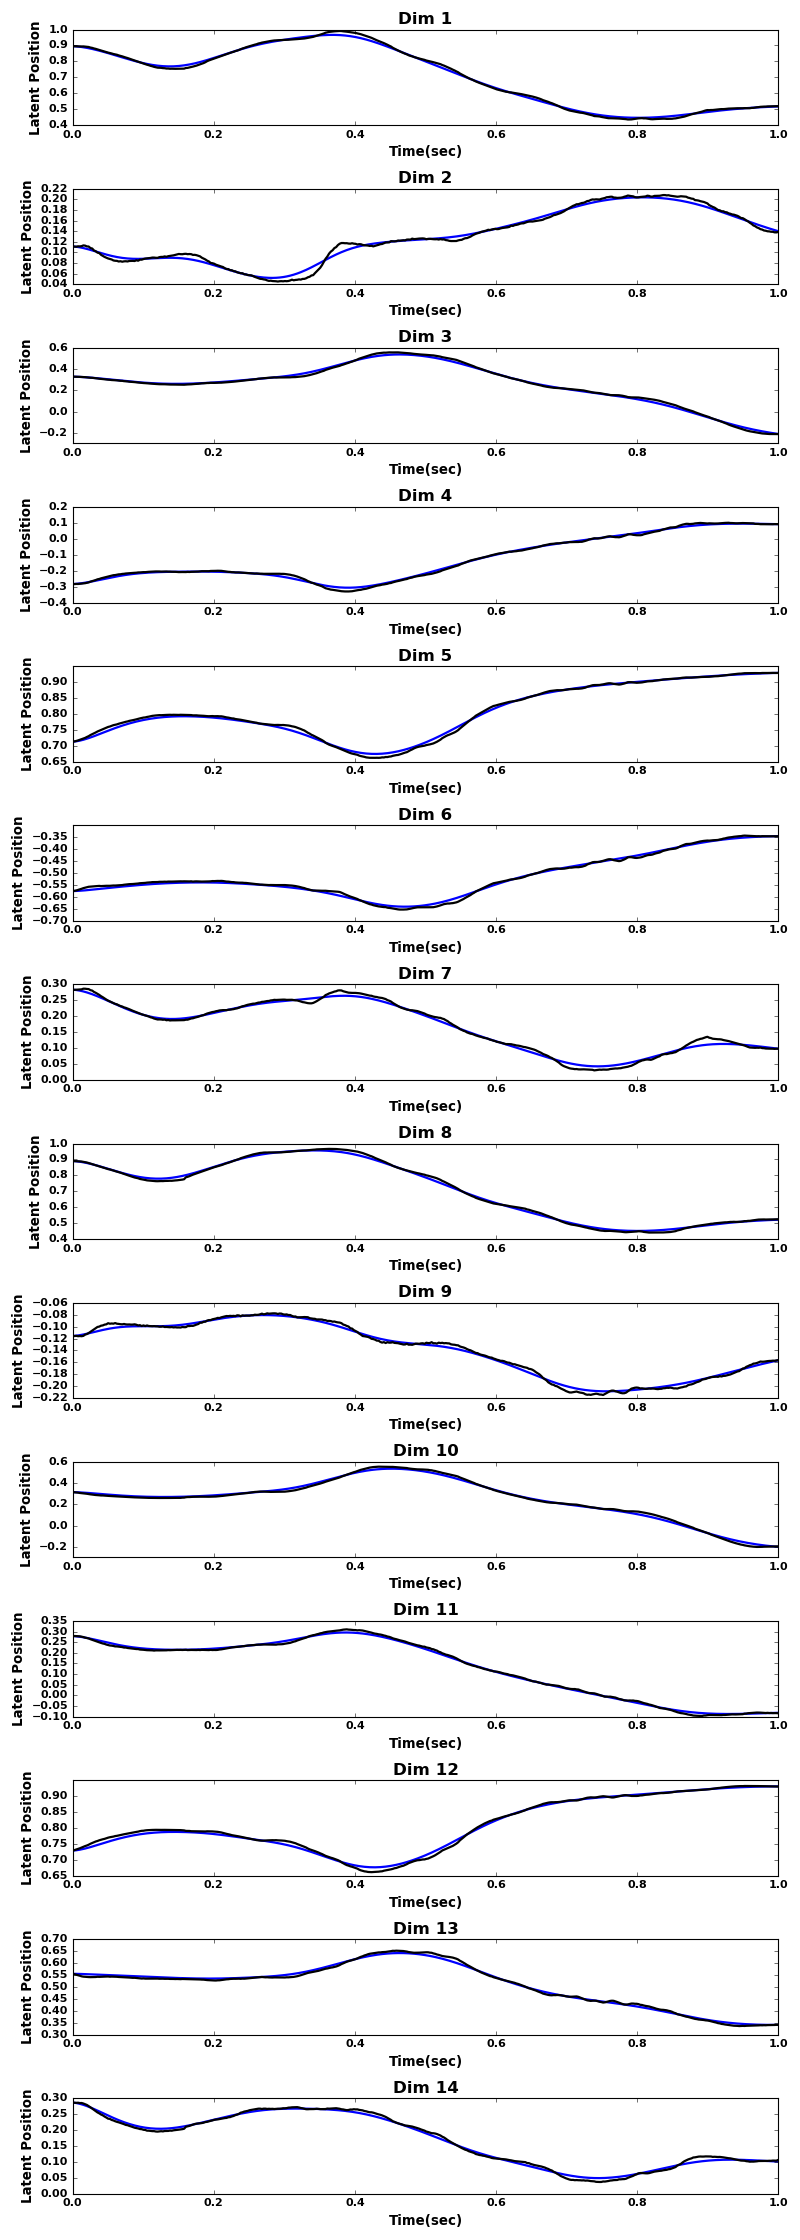

input,EE:Done


<IPython.core.display.Javascript object>


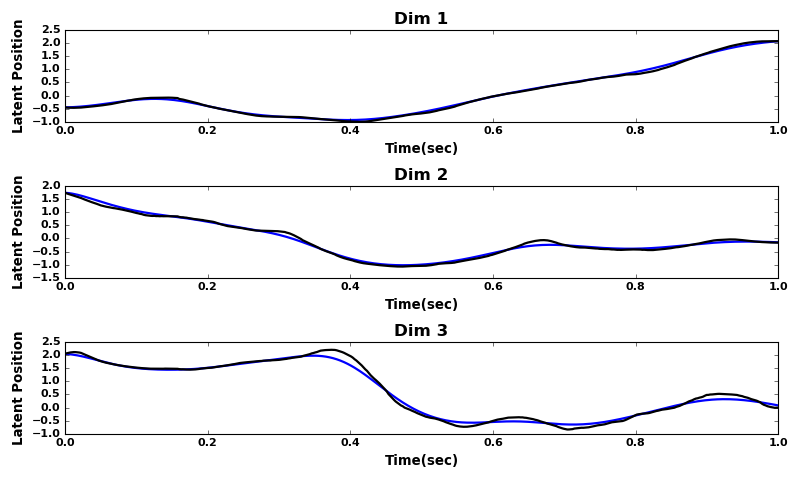

latent,JA:Done


<IPython.core.display.Javascript object>


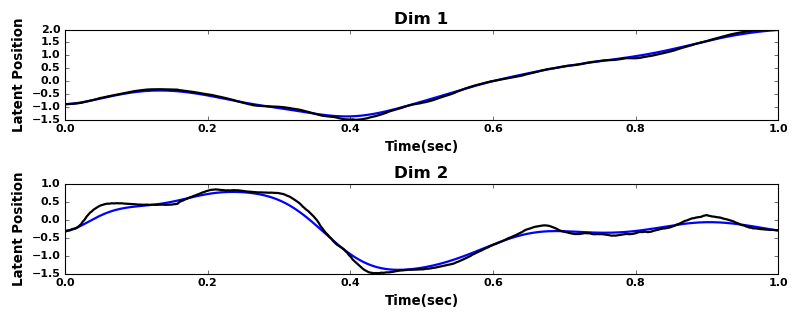

latent,EE:Done


In [34]:
# initialize parameters for training DMPs
nBFS = 100
source = 'Train'
keys = ['JA', 'EE']
modalities = ['input', 'latent']
dims = {'input':{'JA':np.asarray(range(7)+range(8,14)), 'EE':np.arange(15)},
        'latent':{'JA':np.arange(Data['latent']['JA']['Train'].shape[1]),
                  'EE':np.arange(Data['latent']['EE']['Train'].shape[1])}}

dmps = {}
dmpTrajs = {}
for modality in modalities:
    # setup the dicts with modality
    dmps[modality] = {}
    dmpTrajs[modality] = {}
    
    for key in keys:
        # get the relevant dimensions
        inputDim = dims[modality][key]
        data = Data[modality][key][source][:,inputDim]
        
        # initialize parameters to train DMP
        dt = 1.0/data.shape[0]
        nDims = inputDim.shape[0]-1
        
        # setup and train the DMP
        dmp = DMPs_discrete(dmps=nDims, bfs=nBFS, dt=dt)
        dmp.imitate_path(y_des=np.transpose(data[:,1:]))
        
        # generate a rollout from trained DMP
        dmpTraj,_,_ = dmp.rollout()
        dmpTraj = np.concatenate((np.transpose(np.atleast_2d(data[:,0])),dmpTraj),axis=1)
        
        # save the results to dicts
        dmps[modality][key] = dmp
        dmpTrajs[modality][key] = dmpTraj
        
        plotTraj2({'Raw':data,'DMP':dmpTraj}, colors={'Raw':'k','DMP':'b'})
        
        print '%s,%s:Done' % (modality,key)
        
pickle.dump(dmpTrajs, open('Results/DMP.p','wb'))

## Viapoints from Trajectories
---

In [5]:
Data = pickle.load(open('Data/RLData.p','rb'))

<IPython.core.display.Javascript object>


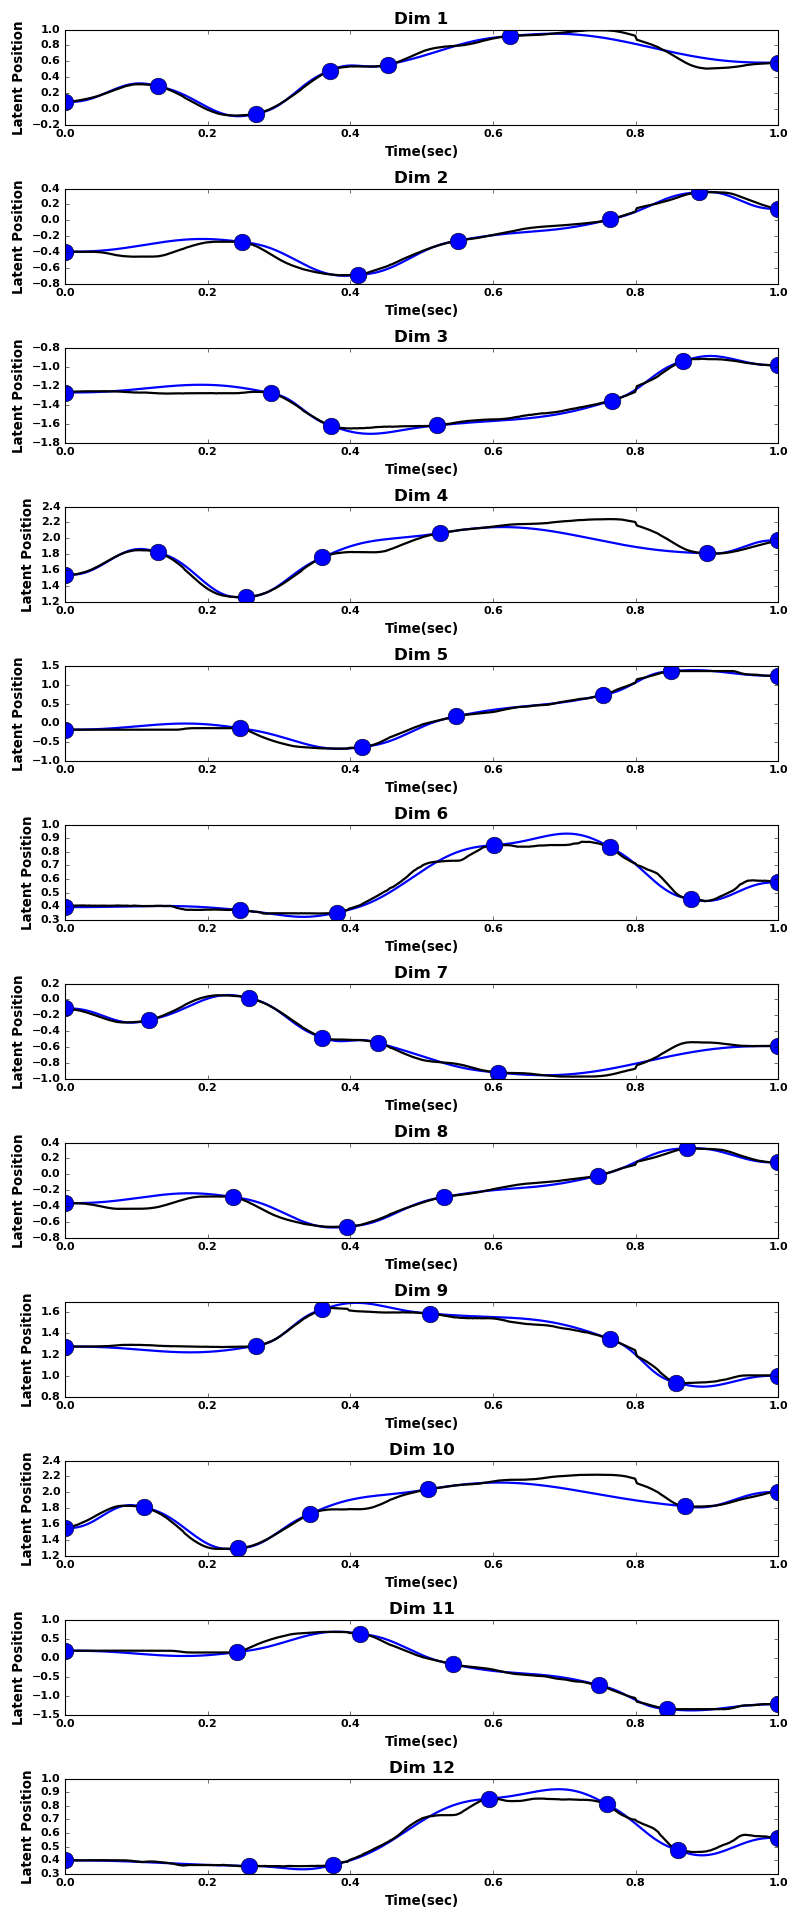

input,JA:Done


<IPython.core.display.Javascript object>


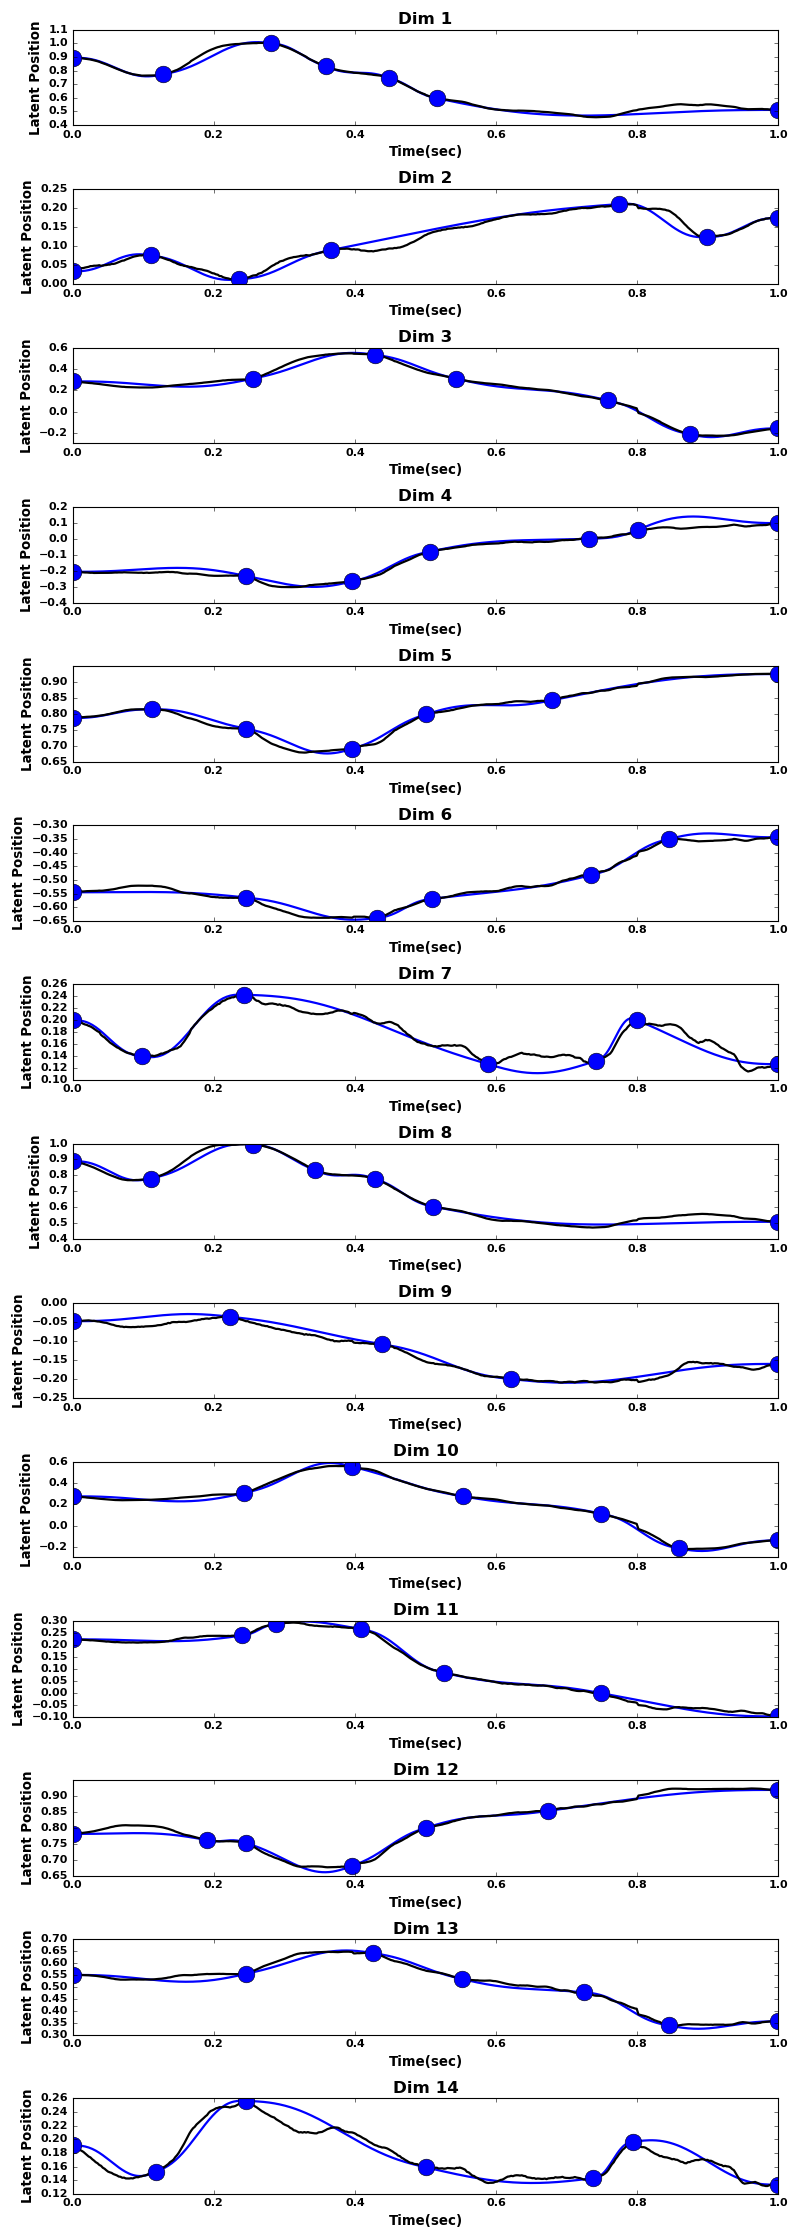

input,EE:Done


In [6]:
# initialize parameters for training DMPs
nVia = 7
source = 'Test'
modality = 'input'
keys = ['JA', 'EE']
dims = {'input':{'JA':np.asarray(range(7)+range(8,14)), 'EE':np.arange(15)}}

# objects and trajectories
viapointObjs = {}
viapointTrajs = {}
viapointParams = {}

for key in keys:
    # get the relevant dimensions
    inputDim = dims[modality][key]
    data = Data[modality][key][source][:,inputDim]
        
    # initialize viapoint extractor instance
    nDims = inputDim.shape[0]-1
    viapoint = ViaPoint(data, nDims=nDims, nViaPoints=nVia, errThresh=0.01)
    (viapointTraj, viapointParam) = viapoint.compute()

    # save the results to dicts
    viapointObjs[key] = viapoint
    viapointTrajs[key] = viapointTraj
    viapointParams[key] = viapointParam
    
    plotTraj2({'Raw':data,'VP':viapointTraj}, points = viapointParam, colors={'Raw':'k','VP':'b'})
    #viapoint.plot(viapointParams)
    print '%s,%s:Done' % (modality,key)
    
VP = {'Trajs':viapointTrajs, 'Params':viapointParams}
pickle.dump(VP, open('Results/VP.p','wb'))    

## Compile DMP, VP results
---

<IPython.core.display.Javascript object>


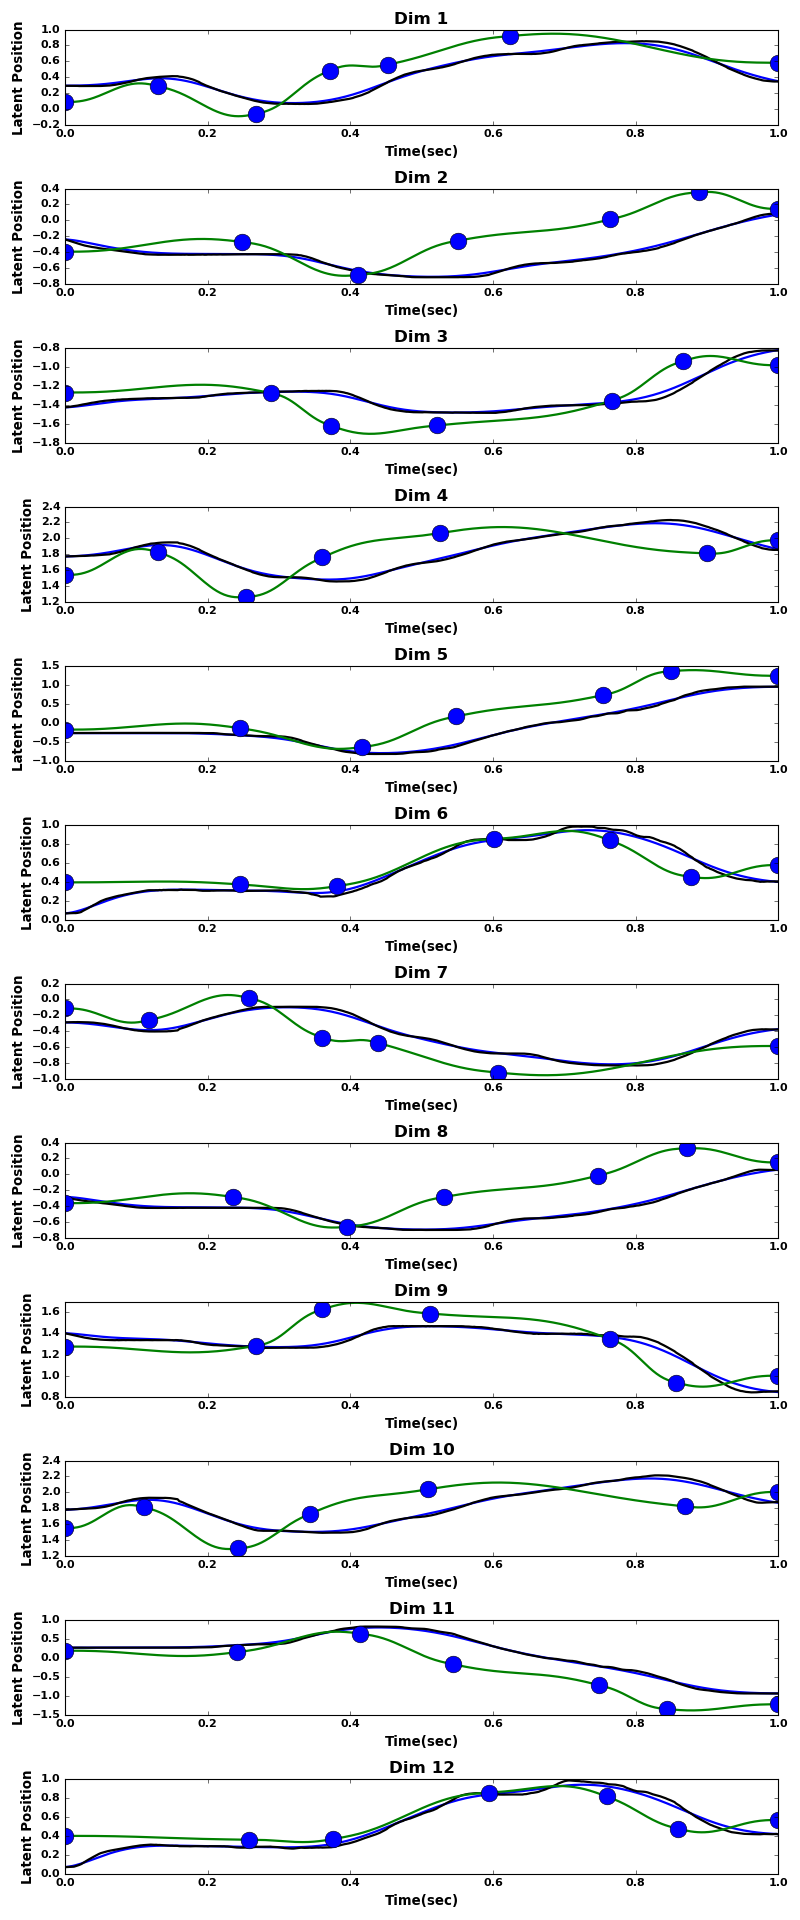

<IPython.core.display.Javascript object>


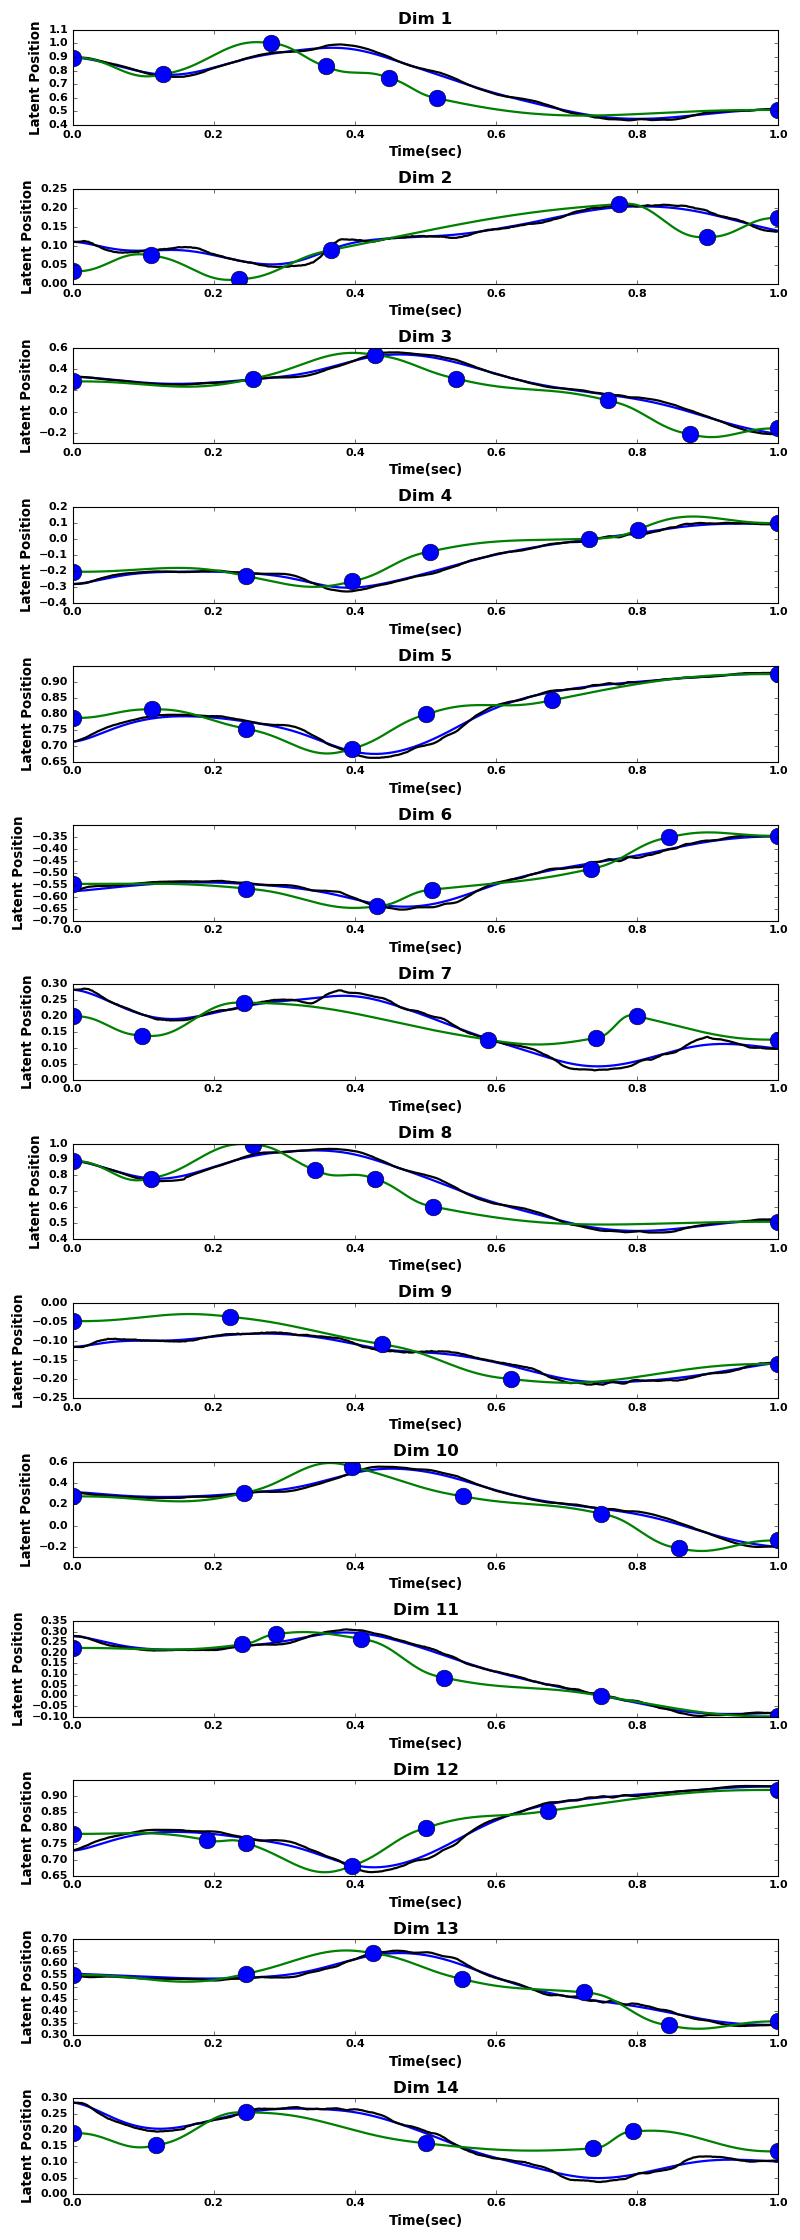

In [7]:
# initialize parameters for training DMPs
source = 'Train'
modality = 'input'
keys = ['JA', 'EE']
dims = {'JA':np.asarray(range(7)+range(8,14)), 'EE':np.arange(15)}

for key in keys:
    # get the relevant dimensions
    inputDim = dims[key]
    dmpTraj = dmpTrajs[modality][key]
    viapointTraj = viapointTrajs[key]
    viapointParam = viapointParams[key]
    data = Data[modality][key][source][:,inputDim]

    plotTraj2({'Raw':data,'DMP':dmpTraj,'VP':viapointTraj}, points=viapointParam, colors={'Raw':'k','DMP':'b','VP':'g'})

## Functions for RL
---

In [32]:
# implement reward function such that trajectory passes through desired via-points
def rewardFunc(trajectory, params):
    # parameter initialization
    reward = 0.0
    vpFactor = 1e2
    nDims = len(params.keys())
    
    # loop over the dimensions
    for nD in range(nDims):
        # get vps and trajectory
        vps = params[nD][:,:2]
        traj = trajectory[:,[0,nD+1]]
        
        # loop over the viapoints
        nVia = params[nD].shape[0]
        for nV in range(nVia):
            idx = (np.abs(traj[:,0]-vps[nV,0])).argmin()
            reward += vpFactor*((traj[idx,1]-vps[nV,1])**2)
    
    # return reward for complete trajectory
    return reward

In [37]:
def inferTraj(model,latTraj):
    # parameter initialization
    dim = model.Y.shape[1]
    lDim = latTraj.shape[1]-1
    nSamples = latTraj.shape[0]
    qDim = model.X.mean.shape[1]
    
    # initialize output trajectory
    outTraj = np.zeros((nSamples,dim+1))
    outTraj[:,0] = latTraj[:,0]
    
    # loop over the samples
    for n in range(nSamples):
        latData = np.zeros((1,qDim))
        latData[0,:lDim] = latTraj[n,1:]
        
        # return output data
        outData,_ = model.predict(latData)
        outTraj[n,1:] = outData
    
    # return the trajectory
    return outTraj

## Cross Entropy Method RL for Input JA Trajectory
---

In [33]:
# dictionary of final rewards for comparison
Rewards = {}

In [35]:
# obtain desired DMP
dmp = dmps['input']['JA']
dmpTraj = dmpTrajs['input']['JA']

# obtain desired via-points
vpParam = viapointParams['JA']

# obtain starting point and goal point for new trajectory
nDims = len(vpParam.keys())

# initialize policy parameters mean
policyMean = dmp.w

# initialize policy variance
policyVar = (policyMean)**2

# do monte-carlo rollouts and evaluate rewards
nKeep = 5
nRollouts = 50
nBFS = policyMean.shape[1]
nSamples = dmpTraj.shape[0]

# save the trajectories
colors = {}
epsRewards = {}
trajectories = {}

# number of iters to run loop
nIters = 50

0 571.958110768
1 528.853772116
2 476.188260344
3 432.449203796
4 403.736322009
5 390.019867136
6 367.232523267
7 350.223106103
8 335.016567636
9 320.516557587
10 311.117059284
11 303.456511151
12 296.47496797
13 291.168281524
14 286.851419763
15 282.776945841
16 279.535849292
17 277.455629293
18 276.127206631
19 274.639640444
20 273.138103372
21 271.991356123
22 270.944603737
23 269.94475093
24 269.110785984
25 268.408170192
26 267.693460779
27 267.19533665
28 266.852338866
29 266.549676461
30 266.252846768
31 266.054775818
32 265.891954431
33 265.756253146
34 265.613493781
35 265.528789634
36 265.444100568
37 265.389517988
38 265.310691924
39 265.276474156
40 265.251825006
41 265.216626414
42 265.182610127
43 265.156837499
44 265.140099511
45 265.123722368
46 265.107715292
47 265.096961532
48 265.084722801
49 265.077893115


<IPython.core.display.Javascript object>


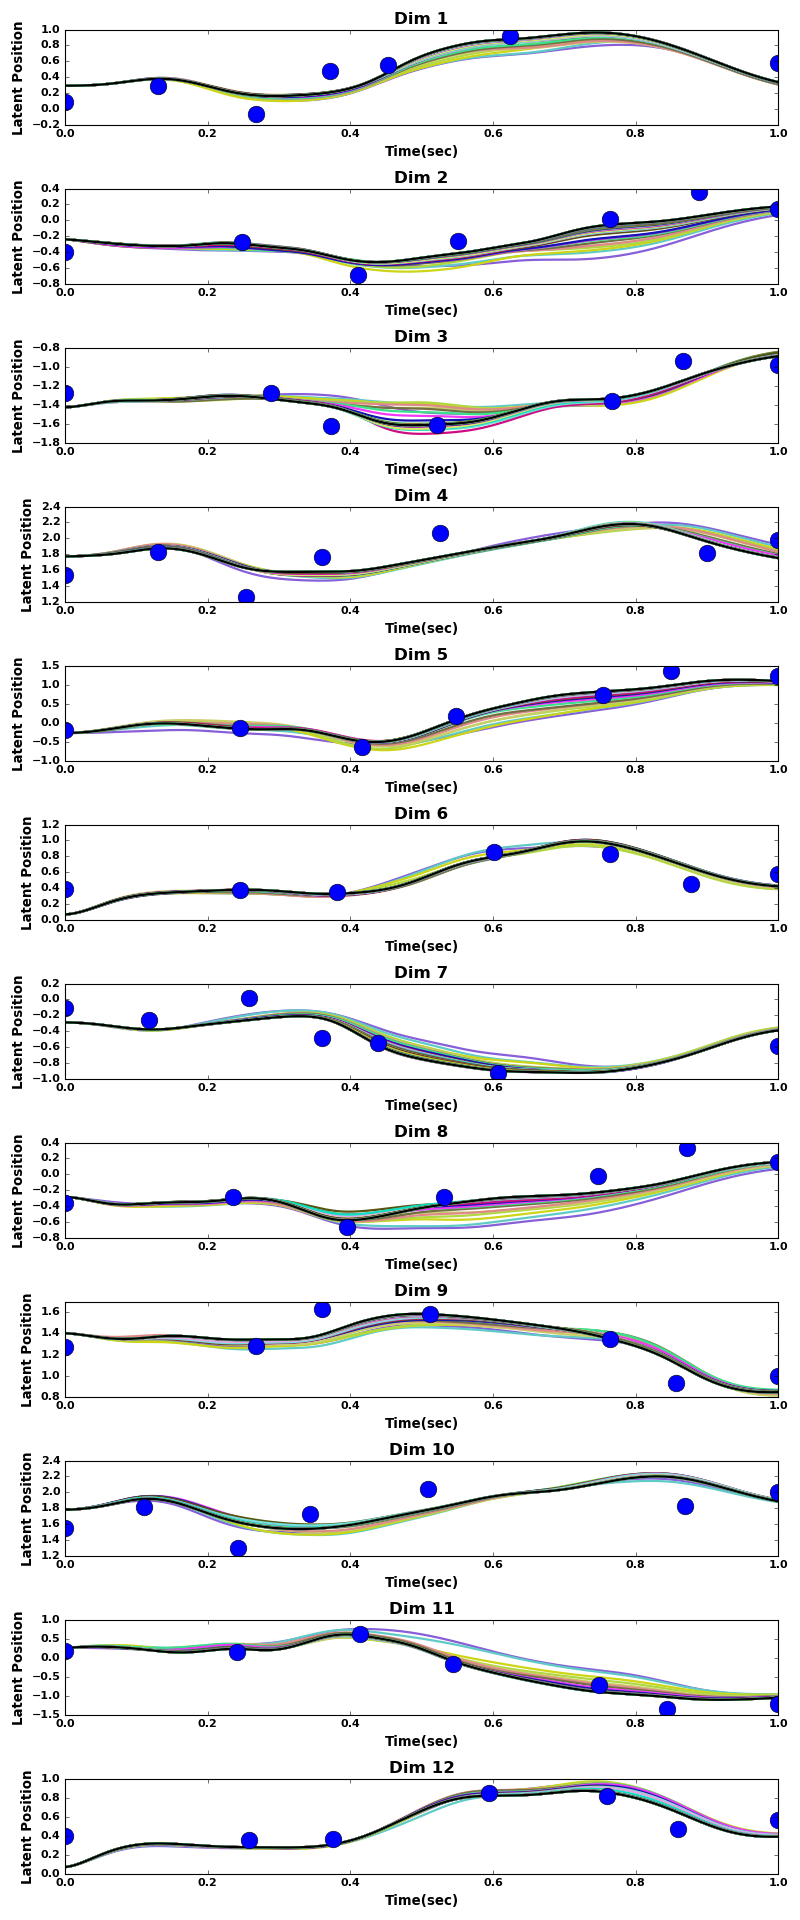

In [36]:
for it in range(nIters):
    trajs = {}
    rollouts = {}
    
    for nR in range(nRollouts):
        # parameter rollout
        rollout = policyMean.copy()
    
        # generate the rollout parameters 
        for d in range(nDims):
            mean = policyMean[d,:]
            cov = (policyVar[d,:])*np.eye(nBFS)
            rollout[d,:] = np.random.multivariate_normal(mean,cov)
        
        # generate trajectory from parameters
        rollouts[nR] = rollout
        dmp.w = rollouts[nR]
        dmpTraj,_,_ = dmp.rollout()
        dmpTraj = np.concatenate((np.transpose(np.atleast_2d(dmpTrajs['input']['JA'][:,0])),dmpTraj),axis=1)
    
        trajs[nR] = dmpTraj

    # compute rewards for all the trajectories
    rewards = np.zeros(nRollouts)
    for key in trajs.keys():
        rewards[key] = rewardFunc(trajs[key],vpParam)
    
    # sort the rewards and keep the top few trials
    trajInds = rewards.argsort()[:nKeep]

    # obtain the best trajectories and policy parameters
    bestPolicies = np.zeros((nKeep,nDims,nBFS))
    for ind,trajInd in enumerate(trajInds):
        bestPolicies[ind,:,:] = rollouts[trajInd]

    # compute new means and variances for policy parameters
    policyMean = bestPolicies.mean(axis=0)
    policyVar = bestPolicies.var(axis=0)

    # generate trajectory from dmp
    dmp.w = policyMean
    dmpTraj,_,_ = dmp.rollout()
    dmpTraj = np.concatenate((np.transpose(np.atleast_2d(dmpTrajs['input']['JA'][:,0])),dmpTraj),axis=1)
    
    trajectories[it] = dmpTraj
    colors[it] = np.random.rand(3,)
    epsRewards[it] = rewardFunc(trajectories[it],vpParam)
    
    print it, epsRewards[it]

Rewards['Org'] = epsRewards.copy()

colors['Org'] = 'k'
trajectories['Org'] = dmpTraj

plotTraj2(trajectories, points=vpParam, colors=colors)

## CEM RL for JA Latent Case
---

In [38]:
# obtain desired DMP
model = models['JA']
dmp = dmps['latent']['JA']
dmpTraj = dmpTrajs['latent']['JA']

# obtain desired via-points
vpParam = viapointParams['JA']

# number of dimensions in dmp
nDims = dmpTraj.shape[1]-1

# initialize policy parameters mean
policyMean = dmp.w

# initialize policy variance
policyVar = (policyMean)**2

# do monte-carlo rollouts and evaluate rewards
nKeep = 5
nRollouts = 50
nBFS = policyMean.shape[1]
nSamples = dmpTraj.shape[0]

# save the trajectories
colors = {}
epsRewards = {}
trajectories = {}

# number of iters to run loop
nIters = 50

0 407.607242389
1 275.230377982
2 241.460657441
3 225.086736573
4 210.955566231
5 200.729695014
6 194.956786026
7 188.019383279
8 183.431080721
9 182.55735038
10 180.247368817
11 178.248883721
12 175.557765
13 174.680644703
14 173.396919955
15 171.961800398
16 170.944250154
17 170.196132318
18 169.122544991
19 168.668318802
20 168.259946395
21 167.86687119
22 167.489608133
23 167.183029234
24 166.944980711
25 166.727305174
26 166.541541323
27 166.412035021
28 166.310930153
29 166.208864127
30 166.122190787
31 166.070511531
32 165.99980123
33 165.95436718
34 165.923177069
35 165.896503392
36 165.869663997
37 165.855955093
38 165.84286247
39 165.832563382
40 165.819427199
41 165.808932777
42 165.800152033
43 165.79438526
44 165.788354437
45 165.784805188
46 165.78095558
47 165.778015778
48 165.775733103
49 165.774485955


<IPython.core.display.Javascript object>


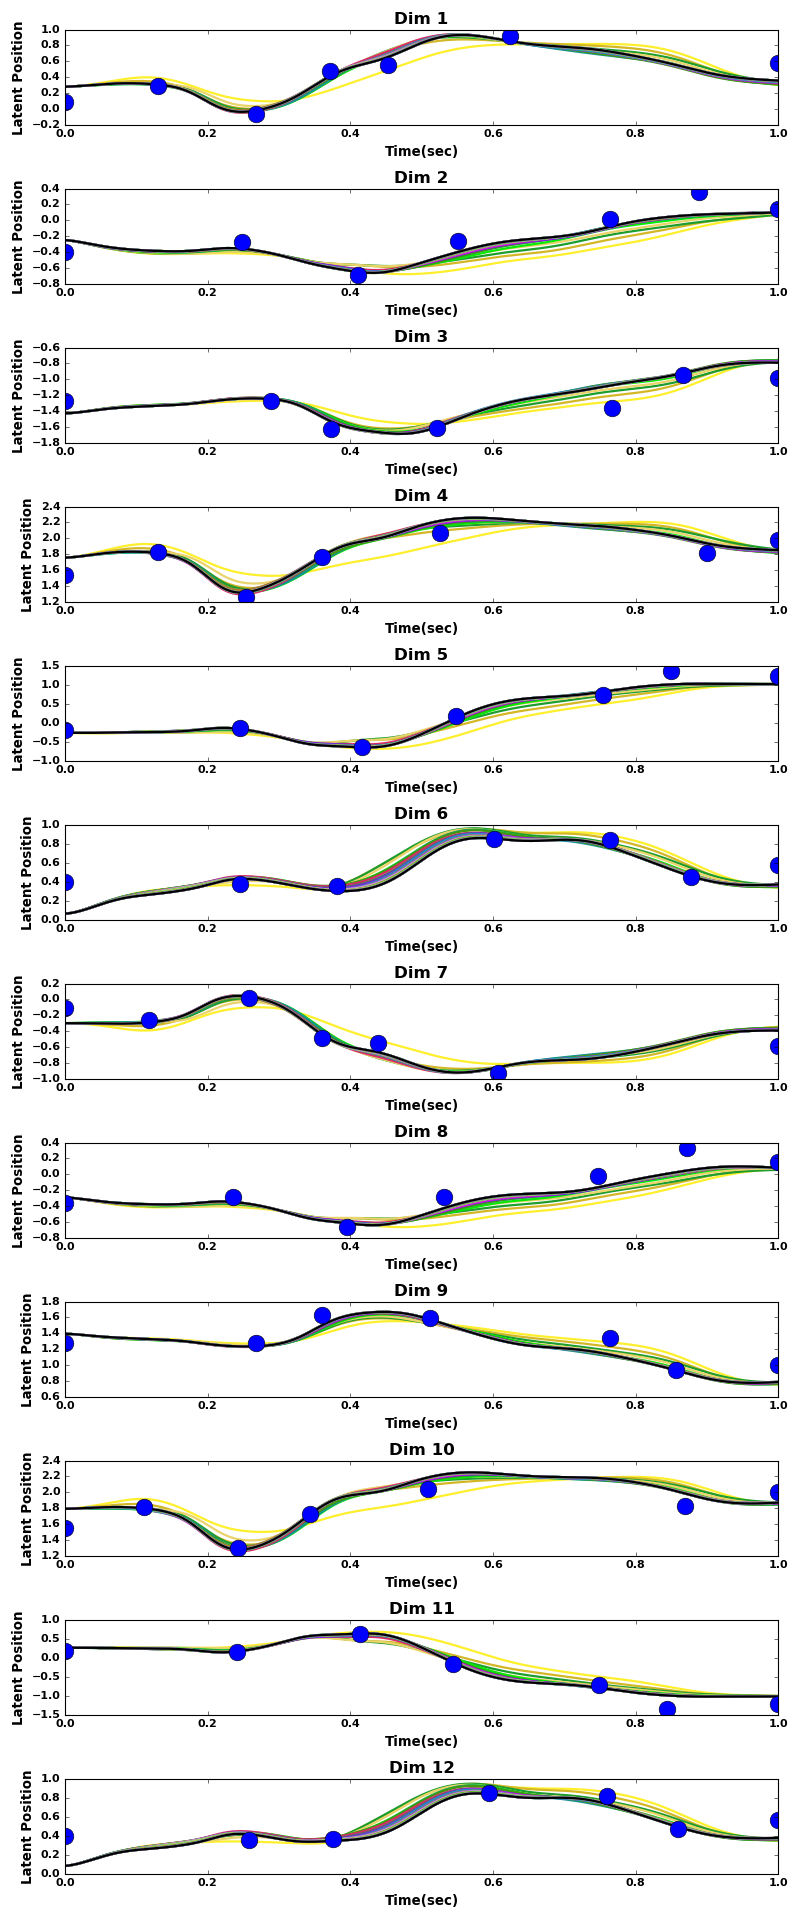

In [39]:
for it in range(nIters):
    trajs = {}
    rollouts = {}
    
    for nR in range(nRollouts):
        # parameter rollout
        rollout = policyMean.copy()
    
        # generate the rollout parameters 
        for d in range(nDims):
            mean = policyMean[d,:]
            cov = (policyVar[d,:])*np.eye(nBFS)
            rollout[d,:] = np.random.multivariate_normal(mean,cov)
        
        # generate trajectory from parameters
        rollouts[nR] = rollout
        dmp.w = rollouts[nR]
        dmpTraj,_,_ = dmp.rollout()
        dmpTraj = np.concatenate((np.transpose(np.atleast_2d(dmpTrajs['input']['JA'][:,0])),dmpTraj),axis=1)

        outputTraj = inferTraj(model,dmpTraj)
        outputTraj = outputTraj[:,dims['input']['JA']]
        trajs[nR] = outputTraj

    # compute rewards for all the trajectories
    rewards = np.zeros(nRollouts)
    for key in trajs.keys():
        rewards[key] = rewardFunc(trajs[key],vpParam)
    
    # sort the rewards and keep the top few trials
    trajInds = rewards.argsort()[:nKeep]

    # obtain the best trajectories and policy parameters
    bestPolicies = np.zeros((nKeep,nDims,nBFS))
    for ind,trajInd in enumerate(trajInds):
        bestPolicies[ind,:,:] = rollouts[trajInd]

    # compute new means and variances for policy parameters
    policyMean = bestPolicies.mean(axis=0)
    policyVar = bestPolicies.var(axis=0)

    # generate trajectory from dmp
    dmp.w = policyMean
    dmpTraj,_,_ = dmp.rollout()
    dmpTraj = np.concatenate((np.transpose(np.atleast_2d(dmpTrajs['latent']['JA'][:,0])),dmpTraj),axis=1)
    
    # generate output trajectory
    outputTraj = inferTraj(model,dmpTraj)
    outputTraj = outputTraj[:,dims['input']['JA']]    
    
    # save results
    trajectories[it] = outputTraj
    colors[it] = np.random.rand(3,)
    epsRewards[it] = rewardFunc(trajectories[it],vpParam)
    
    print it, epsRewards[it]

Rewards['Lat'] = epsRewards.copy()
    
colors['Org'] = 'k'
trajectories['Org'] = outputTraj

plotTraj2(trajectories, points=vpParam, colors=colors)

## Model Comparison
---

<IPython.core.display.Javascript object>


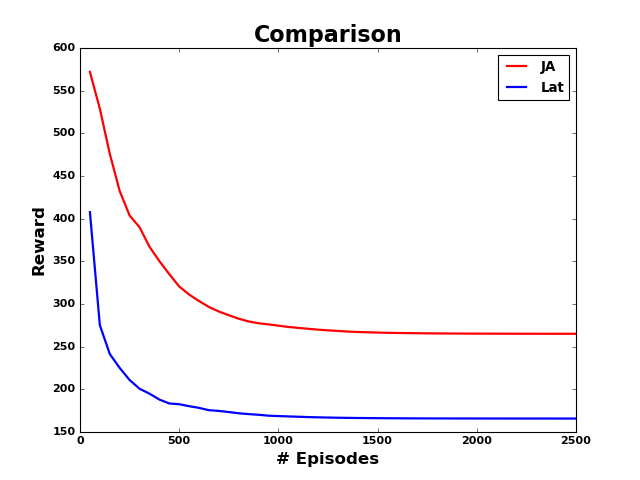

In [40]:
fig = plt.figure()
xDat = 50*np.arange(1,51)
plt.plot(xDat, Rewards['Org'].values(), label='JA', color='r', linewidth=2)
plt.plot(xDat, Rewards['Lat'].values(), label='Lat', color='b', linewidth=2)

plt.xlabel('# Episodes', fontsize=15, fontweight='bold')
plt.ylabel('Reward', fontsize=15, fontweight='bold')
plt.title('Comparison', fontsize=20, fontweight='bold')

plt.legend()
plt.show()

## Cross Entropy Method RL for Input EE Trajectory
---

In [42]:
Rewards = {}

In [41]:
# obtain desired DMP
dmp = dmps['input']['EE']
dmpTraj = dmpTrajs['input']['EE']

# obtain desired via-points
vpParam = viapointParams['EE']

# obtain starting point and goal point for new trajectory
nDims = len(vpParam.keys())

# initialize policy parameters mean
policyMean = dmp.w

# initialize policy variance
policyVar = (policyMean)**2

# do monte-carlo rollouts and evaluate rewards
nKeep = 5
nRollouts = 50
nBFS = policyMean.shape[1]
nSamples = dmpTraj.shape[0]

# save the trajectories
colors = {}
epsRewards = {}
trajectories = {}

# number of iters to run loop
nIters = 50

0 37.4763655336
1 33.1249479253
2 30.9721284085
3 28.5555278874
4 27.3778739037
5 26.3648274362
6 24.8712398206
7 23.9310911499
8 22.9689529304
9 22.2230901235
10 21.7440805571
11 21.2199260917
12 20.6867574625
13 20.3754064653
14 20.1870272797
15 20.02956728
16 19.907955874
17 19.751101948
18 19.5999675736
19 19.5158120263
20 19.4213286053
21 19.3540148233
22 19.3032152987
23 19.2519027577
24 19.2121180326
25 19.1814367146
26 19.1554916789
27 19.1369290777
28 19.1129161178
29 19.09650615
30 19.0824905566
31 19.068370417
32 19.0581937193
33 19.0453335152
34 19.0385700792
35 19.0329625396
36 19.0259449331
37 19.0201487921
38 19.0141472121
39 19.0103954677
40 19.0081656139
41 19.0053640362
42 19.0040819076
43 19.0025118469
44 19.0009250557
45 18.9998557654
46 18.9988288924
47 18.9978189839
48 18.9968331489
49 18.9961039477


<IPython.core.display.Javascript object>


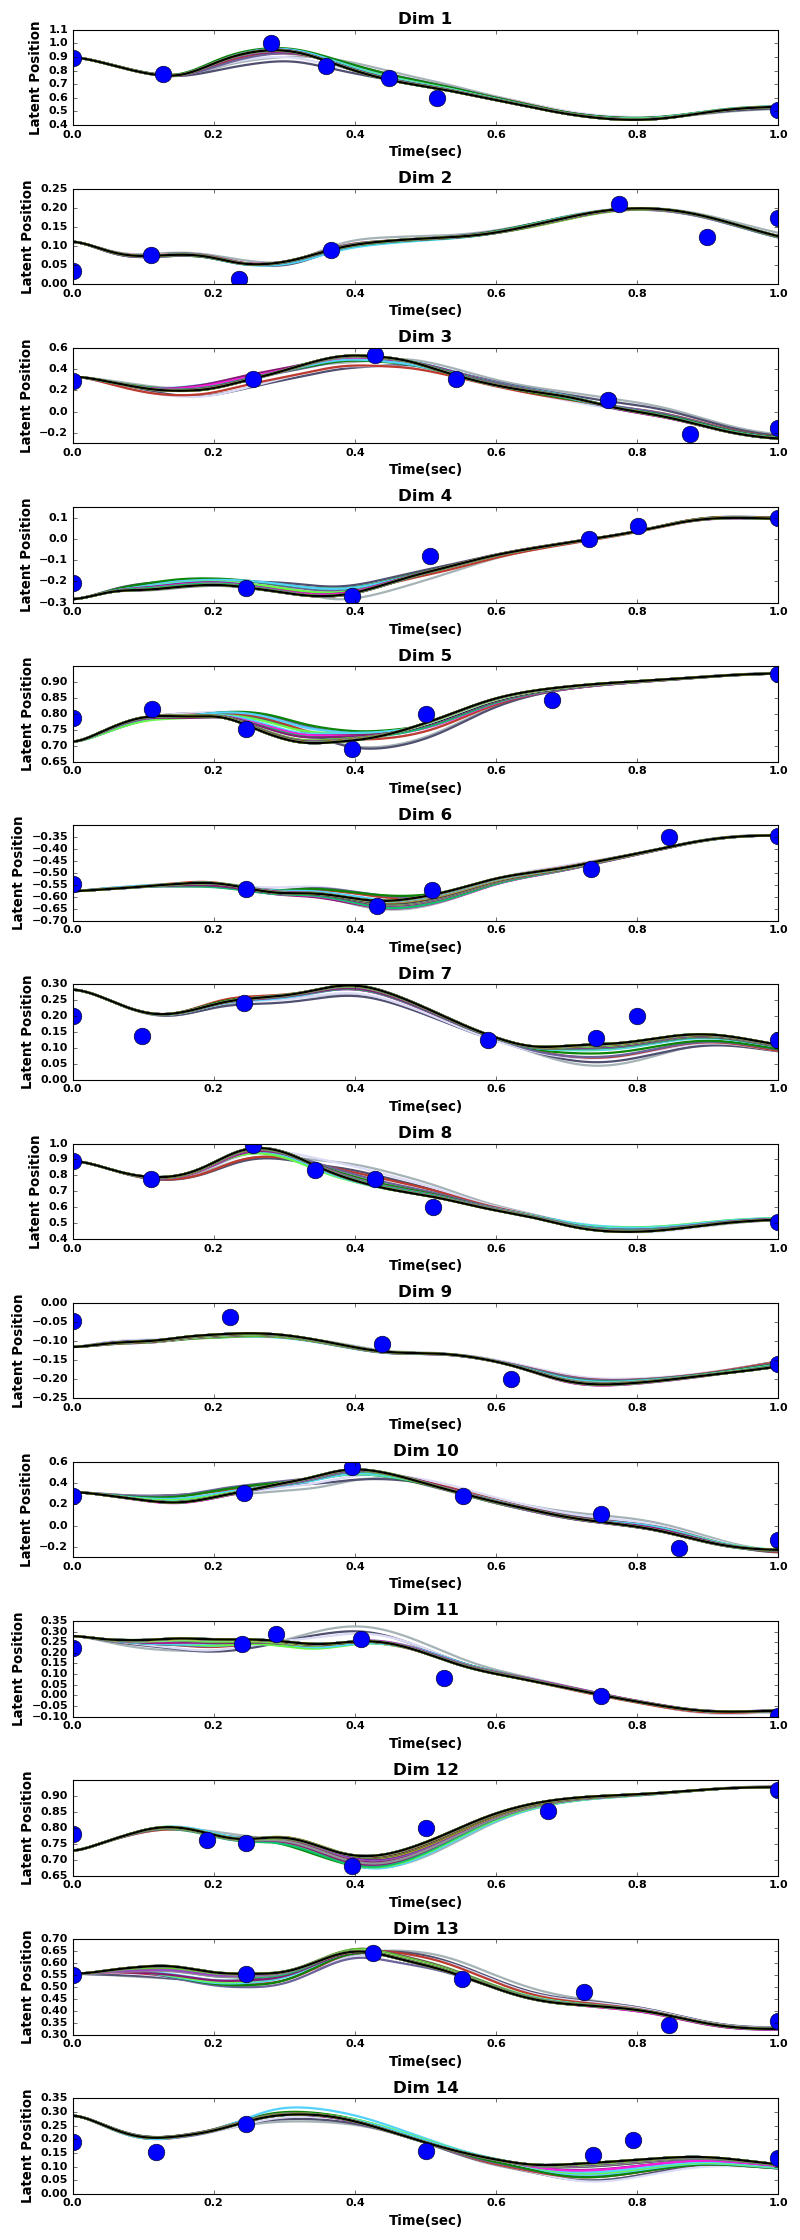

In [43]:
for it in range(nIters):
    trajs = {}
    rollouts = {}
    
    for nR in range(nRollouts):
        # parameter rollout
        rollout = policyMean.copy()
    
        # generate the rollout parameters 
        for d in range(nDims):
            mean = policyMean[d,:]
            cov = (policyVar[d,:])*np.eye(nBFS)
            rollout[d,:] = np.random.multivariate_normal(mean,cov)
        
        # generate trajectory from parameters
        rollouts[nR] = rollout
        dmp.w = rollouts[nR]
        dmpTraj,_,_ = dmp.rollout()
        dmpTraj = np.concatenate((np.transpose(np.atleast_2d(dmpTrajs['input']['EE'][:,0])),dmpTraj),axis=1)
    
        trajs[nR] = dmpTraj

    # compute rewards for all the trajectories
    rewards = np.zeros(nRollouts)
    for key in trajs.keys():
        rewards[key] = rewardFunc(trajs[key],vpParam)
    
    # sort the rewards and keep the top few trials
    trajInds = rewards.argsort()[:nKeep]

    # obtain the best trajectories and policy parameters
    bestPolicies = np.zeros((nKeep,nDims,nBFS))
    for ind,trajInd in enumerate(trajInds):
        bestPolicies[ind,:,:] = rollouts[trajInd]

    # compute new means and variances for policy parameters
    policyMean = bestPolicies.mean(axis=0)
    policyVar = bestPolicies.var(axis=0)

    # generate trajectory from dmp
    dmp.w = policyMean
    dmpTraj,_,_ = dmp.rollout()
    dmpTraj = np.concatenate((np.transpose(np.atleast_2d(dmpTrajs['input']['EE'][:,0])),dmpTraj),axis=1)
    
    trajectories[it] = dmpTraj
    colors[it] = np.random.rand(3,)
    epsRewards[it] = rewardFunc(trajectories[it],vpParam)
    
    print it, epsRewards[it]

Rewards['Org'] = epsRewards.copy()

colors['Org'] = 'k'
trajectories['Org'] = dmpTraj

plotTraj2(trajectories, points=vpParam, colors=colors)

In [44]:
# obtain desired DMP
model = models['EE']
dmp = dmps['latent']['EE']
dmpTraj = dmpTrajs['latent']['EE']

# obtain desired via-points
vpParam = viapointParams['EE']

# number of dimensions in dmp
nDims = dmpTraj.shape[1]-1

# initialize policy parameters mean
policyMean = dmp.w

# initialize policy variance
policyVar = (policyMean)**2

# do monte-carlo rollouts and evaluate rewards
nKeep = 5
nRollouts = 50
nBFS = policyMean.shape[1]
nSamples = dmpTraj.shape[0]

# save the trajectories
colors = {}
epsRewards = {}
trajectories = {}

# number of iters to run loop
nIters = 50

0 25.8532351518
1 22.6411278716
2 21.140825008
3 19.4119057412
4 18.3858042914
5 17.8323574972
6 17.1204215865
7 16.5733639616
8 16.382257687
9 15.836724557
10 15.4764452503
11 15.200765579
12 14.9222641745
13 14.7318346615
14 14.5947407572
15 14.4408243958
16 14.3256613382
17 14.2430821247
18 14.1949797603
19 14.1366211597
20 14.0965619611
21 14.0429881806
22 13.9961124053
23 13.9616415103
24 13.9346802094
25 13.915159486
26 13.8947159914
27 13.8834817345
28 13.8711758748
29 13.8624796206
30 13.857847413
31 13.8528324343
32 13.8500195047
33 13.8475723876
34 13.845252302
35 13.8431912377
36 13.8417948935
37 13.8406054566
38 13.8397347437
39 13.8390859687
40 13.8385896785
41 13.8382566513
42 13.8378619051
43 13.8375882761
44 13.8373168292
45 13.8370755664
46 13.8368367212
47 13.8366581964
48 13.8365610512
49 13.8364748944


<IPython.core.display.Javascript object>


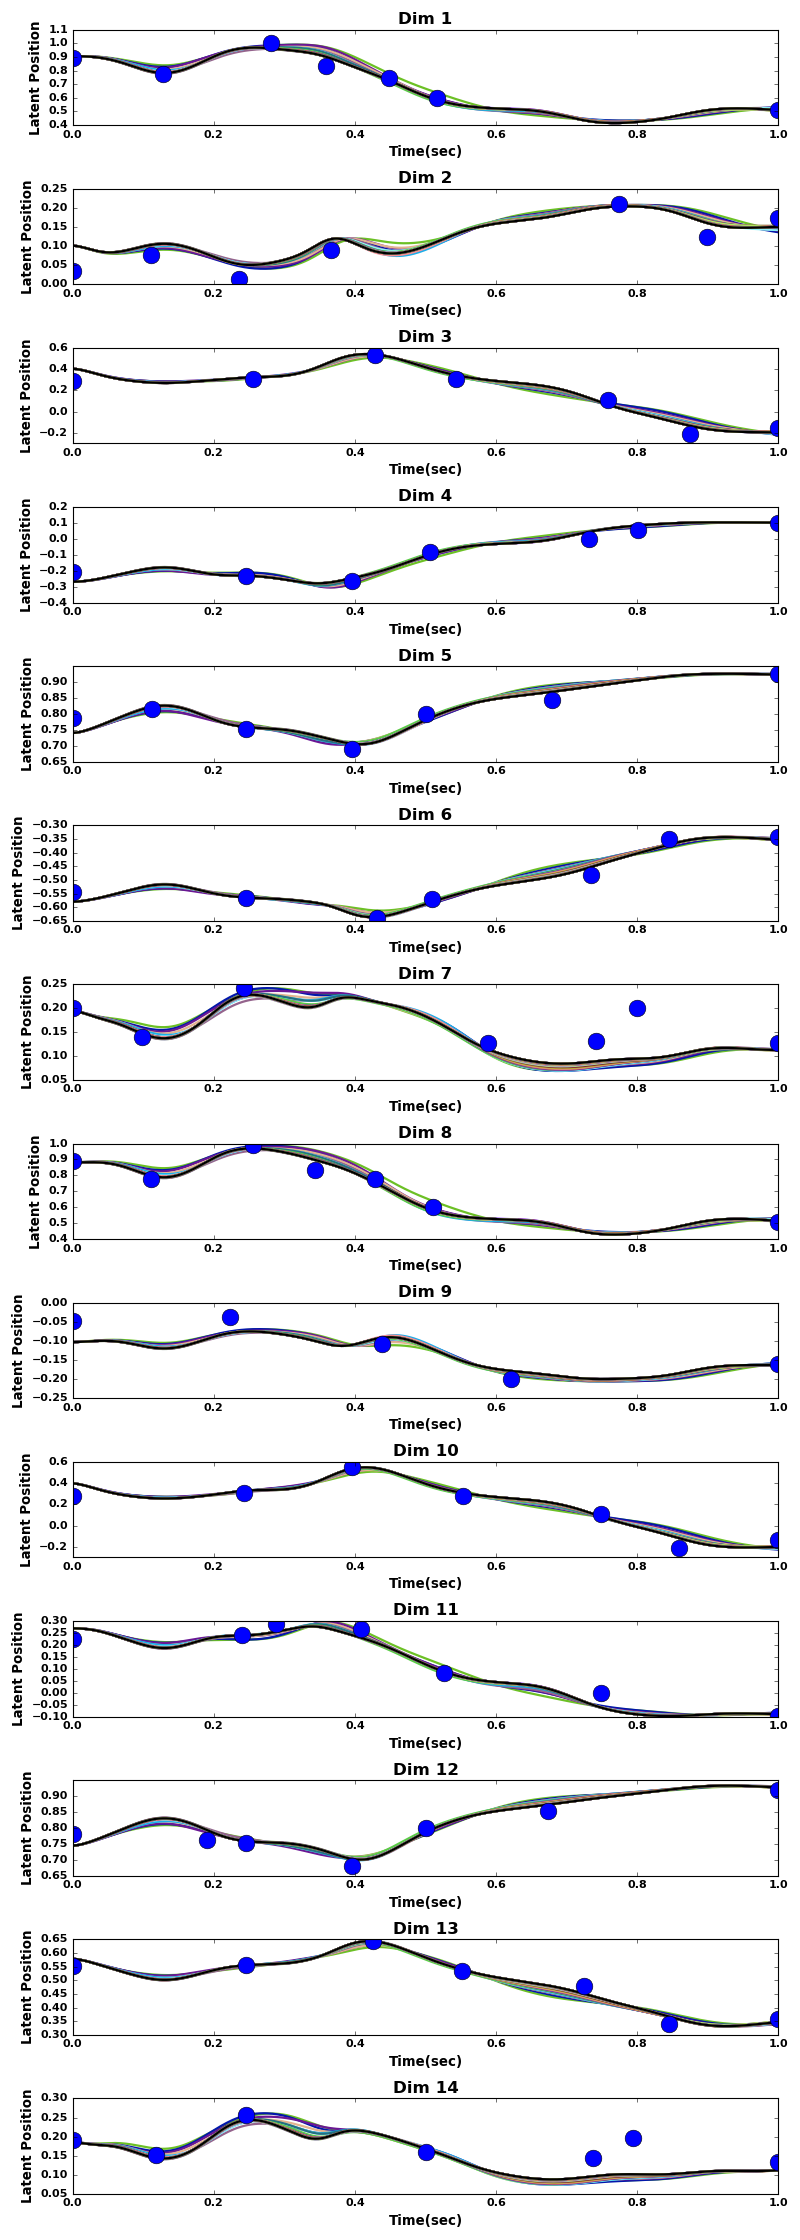

In [45]:
for it in range(nIters):
    trajs = {}
    rollouts = {}
    
    for nR in range(nRollouts):
        # parameter rollout
        rollout = policyMean.copy()
    
        # generate the rollout parameters 
        for d in range(nDims):
            mean = policyMean[d,:]
            cov = (policyVar[d,:])*np.eye(nBFS)
            rollout[d,:] = np.random.multivariate_normal(mean,cov)
        
        # generate trajectory from parameters
        rollouts[nR] = rollout
        dmp.w = rollouts[nR]
        dmpTraj,_,_ = dmp.rollout()
        dmpTraj = np.concatenate((np.transpose(np.atleast_2d(dmpTrajs['input']['EE'][:,0])),dmpTraj),axis=1)

        outputTraj = inferTraj(model,dmpTraj)
        outputTraj = outputTraj[:,dims['input']['EE']]
        trajs[nR] = outputTraj

    # compute rewards for all the trajectories
    rewards = np.zeros(nRollouts)
    for key in trajs.keys():
        rewards[key] = rewardFunc(trajs[key],vpParam)
    
    # sort the rewards and keep the top few trials
    trajInds = rewards.argsort()[:nKeep]

    # obtain the best trajectories and policy parameters
    bestPolicies = np.zeros((nKeep,nDims,nBFS))
    for ind,trajInd in enumerate(trajInds):
        bestPolicies[ind,:,:] = rollouts[trajInd]

    # compute new means and variances for policy parameters
    policyMean = bestPolicies.mean(axis=0)
    policyVar = bestPolicies.var(axis=0)

    # generate trajectory from dmp
    dmp.w = policyMean
    dmpTraj,_,_ = dmp.rollout()
    dmpTraj = np.concatenate((np.transpose(np.atleast_2d(dmpTrajs['latent']['EE'][:,0])),dmpTraj),axis=1)
    
    # generate output trajectory
    outputTraj = inferTraj(model,dmpTraj)
    outputTraj = outputTraj[:,dims['input']['EE']]    
    
    # save results
    trajectories[it] = outputTraj
    colors[it] = np.random.rand(3,)
    epsRewards[it] = rewardFunc(trajectories[it],vpParam)
    
    print it, epsRewards[it]

Rewards['Lat'] = epsRewards.copy()
    
colors['Org'] = 'k'
trajectories['Org'] = outputTraj

plotTraj2(trajectories, points=vpParam, colors=colors)

<IPython.core.display.Javascript object>


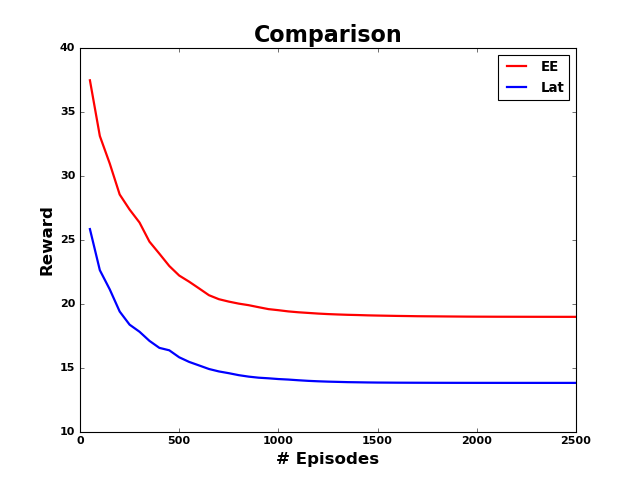

In [47]:
fig = plt.figure()
xDat = 50*np.arange(1,51)
plt.plot(xDat, Rewards['Org'].values(), label='EE', color='r', linewidth=2)
plt.plot(xDat, Rewards['Lat'].values(), label='Lat', color='b', linewidth=2)

plt.xlabel('# Episodes', fontsize=15, fontweight='bold')
plt.ylabel('Reward', fontsize=15, fontweight='bold')
plt.title('Comparison', fontsize=20, fontweight='bold')

plt.legend()
plt.show()